In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [19]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

In [ ]:
analysis_window_length = 2**19    # Length of analysis window in number of indices
search_window_length   = 2**8     # 50 us search window

amp2kev = 13865.146660550492

In [94]:
def get_idx_in_window(amp_searched_idx, search_window_length, lb):
    ret = np.empty_like(amp_searched_idx)

    for i, amp_idx in enumerate(amp_searched_idx):
        ret[i] = amp_idx + lb + search_window_length * i
    
    return ret

def bad_detection_quality(zz_windowed, zz_bp_windowed):
    # Z signal out of balance, meaning that homodyne losing lock
    if np.abs(np.mean(zz_windowed)) > 0.25:
        return True
    
    if np.max(np.abs(zz_windowed)) > 0.95:
        return True

    # Check the sum over 100 indices to see if there
    # is a consecutive period of very small signal after bandpass
    convolved = np.convolve(np.abs(zz_bp_windowed),np.ones(100, dtype=int), 'valid')
    if np.sum(convolved < 1e-3) > 0:
        return True

In [44]:
file = r'/Volumes/LaCie/gas_collisions/background_data/sphere_20251212/20251215_p8e_5e-8mbar/20251215_df_0.hdf5'

f = h5py.File(file, "r")

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

f.close()

In [96]:
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 60000, 2)
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / analysis_window_length), analysis_window_length))
zz_shaped = np.reshape(zz, (int(zz_bp.size / analysis_window_length), analysis_window_length))

amp_all = np.empty(shape=(zz_bp_shaped.shape[0], int(analysis_window_length/search_window_length)-3), dtype=np.float64)
good_detection  = np.full(shape=zz_bp_shaped.shape[0], fill_value=True)

In [97]:
lb, ub = 2 * search_window_length, -1 * search_window_length

for j, _zz_bp in enumerate(zz_bp_shaped):
    amp, amp_lp = utils.recon_force(dtt, _zz_bp, 60000)

    # Throw away the beginning and the end of the reconstructed amplitudes
    # to avoid windowing effects
    amp_search = np.abs(amp_lp[lb:ub])
    amp_reshaped = np.reshape(amp_search, (int(amp_search.size/search_window_length), search_window_length))

    amp_searched_idx = np.argmax(amp_reshaped, axis=1)
    amp_searched_idx_in_window = get_idx_in_window(amp_searched_idx, search_window_length, lb)

    amp_all[j] = amp_lp[amp_searched_idx_in_window]

    # Identify period of poor detection quality
    if bad_detection_quality(zz_shaped[j], zz_bp_shaped[j]):
        good_detection[j] = False

Text(0, 0.5, 'Counts/(50 keV/c)')

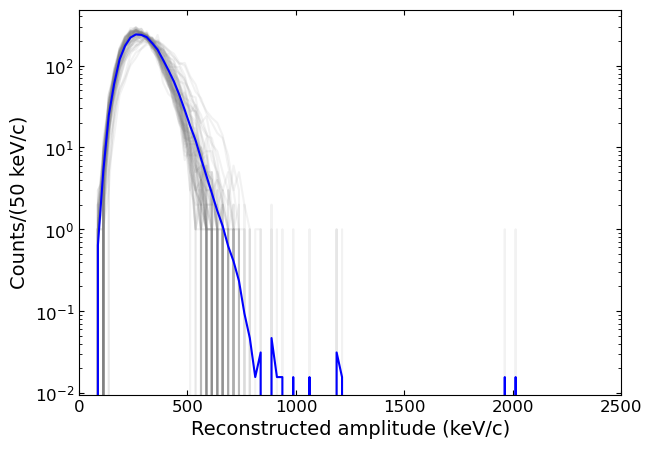

In [101]:
bins = np.arange(0, 10000, 25)  # keV
bc = 0.5 * (bins[:-1] + bins[1:])

for j, amps in enumerate(amp_all):
    hh, _ = np.histogram(np.abs(amps) * amp2kev, bins)

    if not good_detection[j]:
        plt.plot(bc, hh, 'red', alpha=0.3)
    else:
        plt.plot(bc, hh, 'gray', alpha=0.1)

hh, _ = np.histogram(np.abs(amp_all.flatten()) * amp2kev, bins)
plt.plot(bc, hh/amp_all.shape[0], 'b')

plt.xlim(0, 2500)
plt.yscale('log')

plt.xlabel('Reconstructed amplitude (keV/c)')
plt.ylabel('Counts/(50 keV/c)')
